<p>GCS modeling simulation based on OOB's ovarian dataset</p>

# Modules and Data loading

In [1]:
import sys
import json

with open('../paths', 'r') as f:
    globals().update(json.loads(f.read()))

sys.path.append(path_Modules_Product_)
sys.path.append(path_Modules_Toolbox_)

In [2]:
import itertools
import pandas as pd
import numpy as np
from scipy import stats as scstats
from sklearn import metrics as skmet
from sklearn import preprocessing as skprep
from sklearn import covariance as skcov
from sklearn.decomposition import PCA as skpca
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import Plots as IcePlot

In [4]:
dataset_base = pd.read_csv(path_data_proprocessed_ + 'dataset/ds_main.csv',
                           index_col=0)
dataset_base = dataset_base.loc[np.isin(dataset_base.s_Tumor,
                                        ['Normal', 'Ovary'])]
dataset_base = dataset_base.loc[(dataset_base.s_Age.between(60, 70))
                                & (dataset_base.s_Sex == 'F')]

In [5]:
dataset_target = pd.read_csv(path_data_proprocessed_ + 'dataset/ds_OOB_C.csv',
                             index_col=0)
dataset_target = dataset_target.loc[np.isin(dataset_target.s_Tumor,
                                            ['Normal', 'Ovary'])]
dataset_target = dataset_target.loc[dataset_target.s_Age.between(60, 70)]
dataset_target.s_Time2dx = dataset_target.s_Time2dx.replace(np.nan,-1)
dataset_target = dataset_target.loc[dataset_target.s_Time2dx<365]
dataset_target['p_HE4']=dataset_target.p_HE4_U.values

potential markers

In [6]:
p1 = [x for x in dataset_base.columns if x.startswith('p_')]
p2 = [x for x in dataset_target.columns if x.startswith('p_')]
markers = np.array(p1)[np.isin(p1, p2)]
print(markers)

['p_CA15-3' 'p_CA125' 'p_CA19-9' 'p_HE4' 'p_KLK6' 'p_LEPTIN'
 'p_MESOTHELIN' 'p_OPN' 'p_PROLACTIN']


In [7]:
# test
markers = ['p_CA15-3', 'p_CA125', 'p_CA19-9', 'p_HE4', 'p_OPN', 'p_PROLACTIN']

In [8]:
markers_l = [f'l_{x[2:]}-limit' for x in markers]
p_rows2 = int(np.ceil(len(markers) / 2))

# Case vs. Control

## Dist.

In [9]:
_, subs = plt.subplots(p_rows2, 2, figsize=(15, 5 * p_rows2))
subs = subs.flatten()
ds = dataset_base.copy()
for c, m in enumerate(markers):
    ds_ = ds[['s_Tumor', m]].dropna()
    ds_[m] = np.log(ds_[m])
    ax = subs[c]
    plt.sca(ax)
    ds_.groupby('s_Tumor', sort=False).apply(lambda x: IcePlot.linespace_kde(
        x, m, label=f'{x["s_Tumor"].iloc[0]}:{len(x)}'))
    plt.title(m)
    plt.legend()
    plt.grid()

## KS

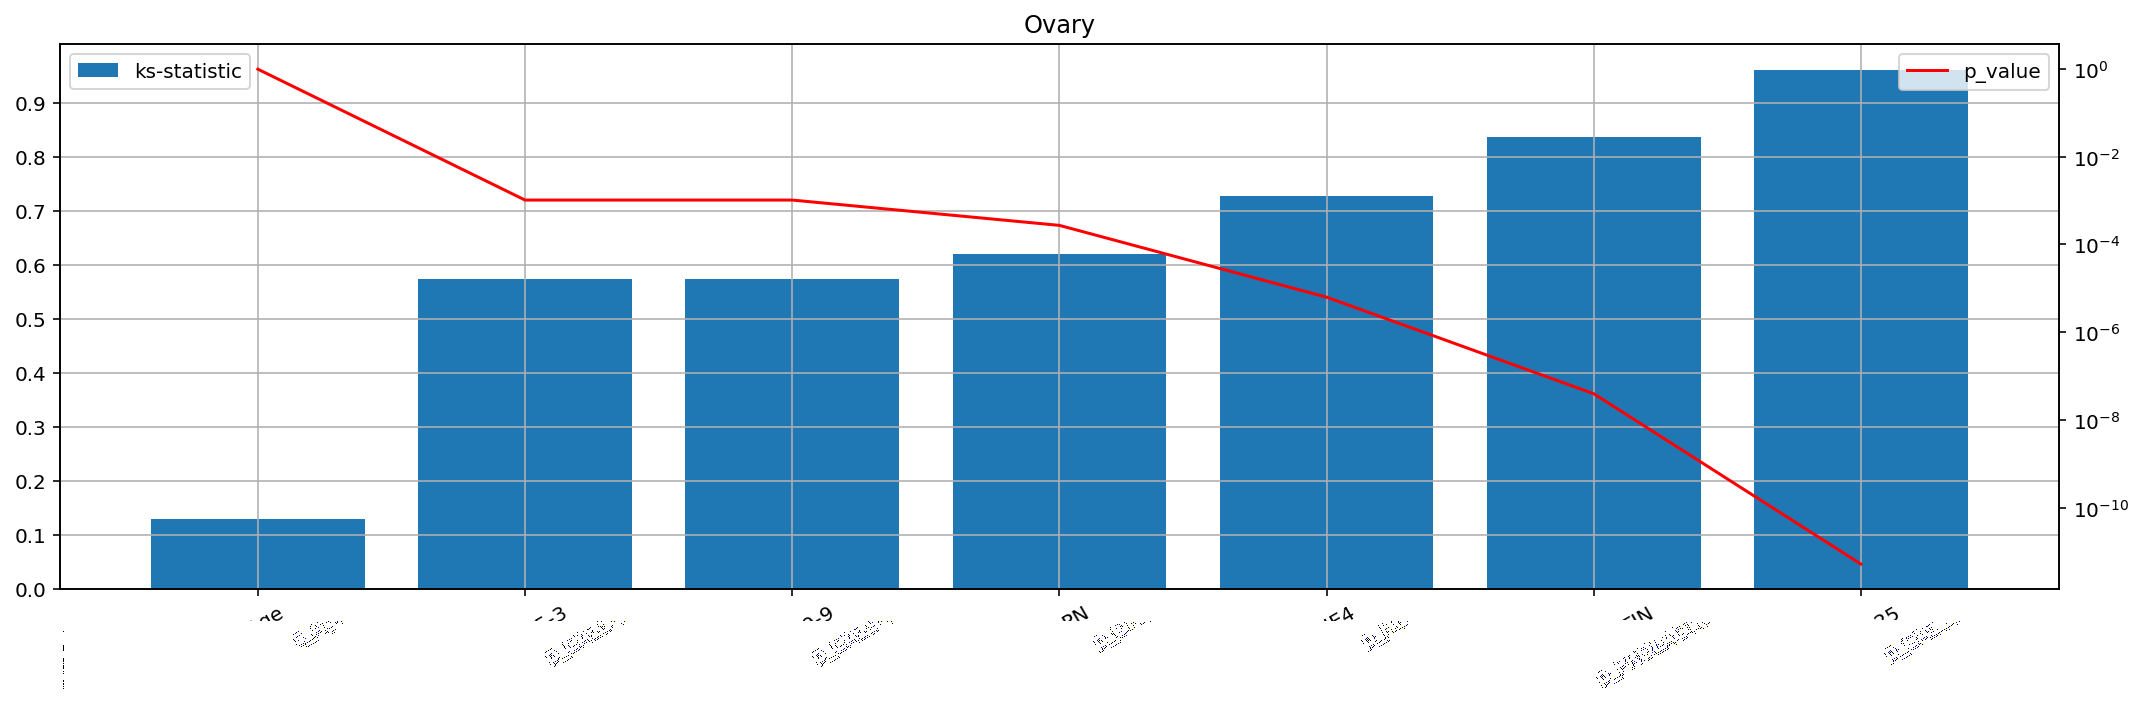

In [11]:
tmp = pd.MultiIndex.from_product((['Ovary'], ['ks', 'p']))
rep = pd.DataFrame(index=markers + ['s_Age'], columns=tmp)
ds = dataset_base.copy()
for m in markers + ['s_Age']:
    ds_ = ds[['s_Tumor', m]].dropna()
    ds_[m] = np.log(ds_[m])
    tmp = ds_.loc[ds_.s_Tumor == 'Normal', [m]].values
    trans = skprep.StandardScaler().fit(tmp)
    ds_[m] = trans.transform(ds_[[m]].values)
    #
    sam_n = ds_.loc[ds_.s_Tumor == 'Normal', m]
    sam_f = ds_.loc[ds_.s_Tumor == 'Ovary', m]
    ks = scstats.ks_2samp(sam_n, sam_f)
    rep.loc[m, 'Ovary'] = (ks.statistic, ks.pvalue)

_, subs = plt.subplots(1, 1, figsize=(15, 5))
r_ = rep['Ovary']
ax = subs
plt.sca(ax)
r_ = r_.sort_values('ks')
plt.bar(r_.index, r_.ks, label='ks-statistic')
plt.title('Ovary')
plt.grid()
plt.xticks(rotation=30)
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='upper left')
ax = plt.twinx(ax)
plt.plot(r_.index, r_.p, color='r', label='p_value')
plt.yscale('log')
plt.legend(loc='upper right')

plt.tight_layout()

## AUC

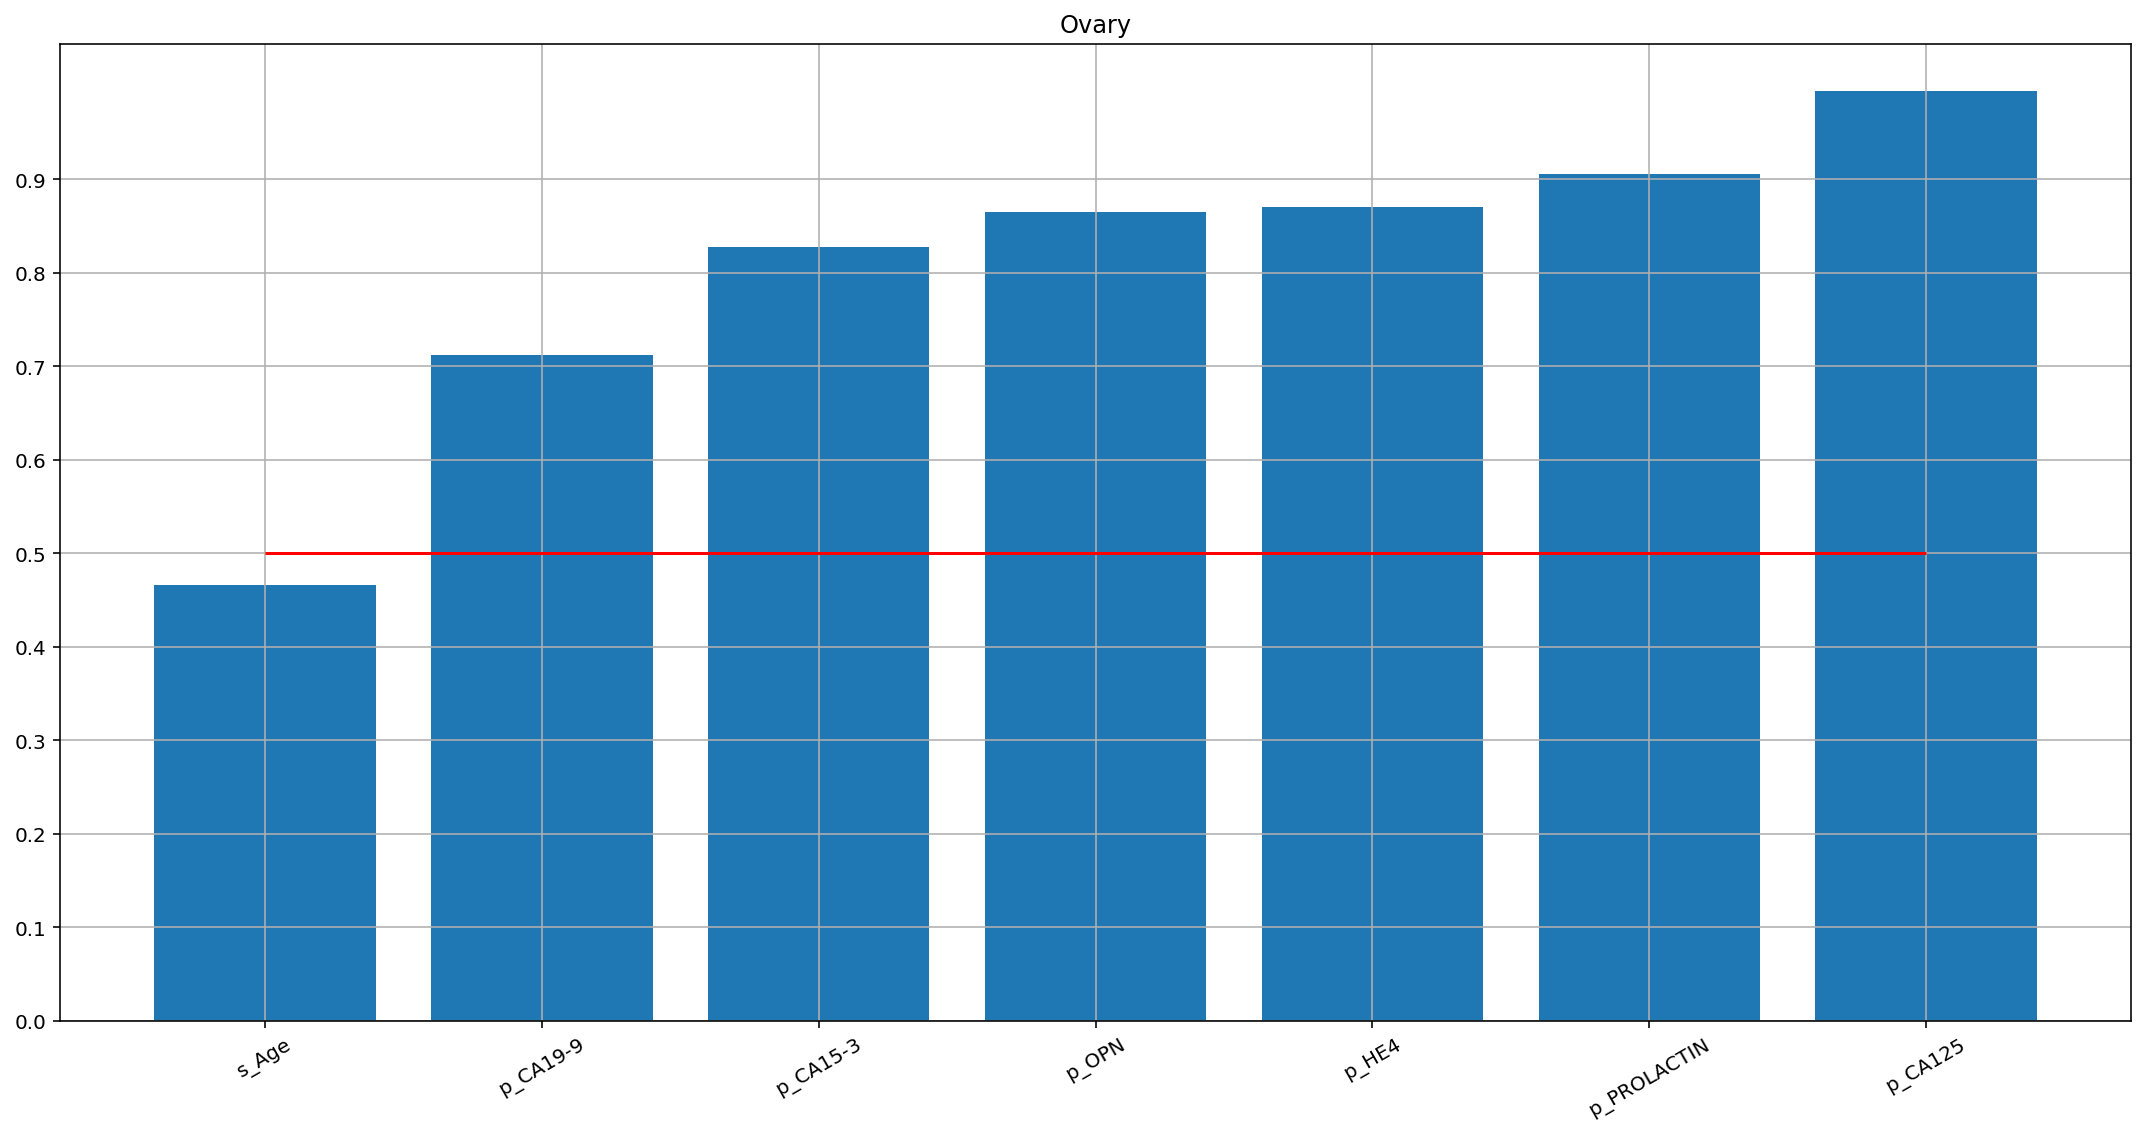

In [12]:
tumor_g = ['Normal', 'Ovary']
rep = pd.DataFrame(index=markers, columns=['Ovary'])
ds = dataset_base.copy()
for m in markers + ['s_Age']:
    ds_ = ds[['s_Tumor', m]].dropna()
    ds_[m] = np.log(ds_[m])
    for t in ['Ovary']:
        ds__ = ds_.loc[np.isin(ds_.s_Tumor, ['Normal', t])].copy()
        ds__['label'] = 0
        ds__.loc[ds__.s_Tumor == t, 'label'] = 1
        auc = skmet.roc_auc_score(ds__.label, ds__[m])
        rep.loc[m, t] = auc
_, subs = plt.subplots(1, 1, figsize=(15, 8))
r_ = rep['Ovary']
ax = subs
plt.sca(ax)
r_ = r_.sort_values()
plt.bar(r_.index, r_.values)
plt.title(t)
plt.grid()
plt.xticks(rotation=30)
plt.yticks(np.arange(0, 1, 0.1))
plt.hlines(0.5, 0, 6, color='r')
plt.tight_layout()

## Stage regression

In [13]:
tumor_g = ['Ovary']
t2 = [1, 2, 3]
ds = dataset_base.loc[np.isin(dataset_base.s_Tumor, tumor_g)].copy()
rep = pd.DataFrame(columns=pd.MultiIndex.from_product(
    [tumor_g, ('slope', 'intercept', 'rvalue', 'pvalue', 'stderr')]))
for m_ in markers + ['s_Age']:
    ds_1 = ds[['s_Tumor', 's_Stage', m_]].dropna()
    ds_1[m_] = np.log(ds_1[m_])
    for t_ in tumor_g:
        ds_2 = ds_1.loc[ds_1.s_Tumor == t_].copy()
        stat = scstats.linregress(ds_2[m_], ds_2['s_Stage'])
        for i_ in ('slope', 'intercept', 'rvalue', 'pvalue', 'stderr'):
            rep.loc[m_, (t_, i_)] = getattr(stat, i_)
_, subs = plt.subplots(1, 1, figsize=(15, 8))
ax = subs
plt.sca(ax)
rep.loc[:, ('Ovary', 'rvalue')].sort_values().plot.bar(ax=ax,
                                                  title=t_,
                                                  grid=True)
plt.legend(['r-stats'])
plt.xticks(rotation=30)
plt.tight_layout()

## Median-reg

## PCA

In [44]:
tumor_g = ['Normal', 'Ovary']
ds = dataset_base.loc[np.isin(dataset_base.s_Tumor, tumor_g)].copy()
# markers_ = ['p_HE4', 's_Age']
markers_ = markers
ds[markers_] = np.log(ds[markers_])
p_ = skpca(2).fit(ds[markers_])
d_ = p_.transform(ds[markers_])
d_ = pd.DataFrame(d_, columns=['pcax', 'pcay'])
d_['tumor'] = ds.s_Tumor.values
d_['stage'] = ds.s_Stage.values
px.scatter(d_, 'pcax', 'pcay', color='tumor',hover_data=['stage'])

# Sim

In [366]:
ds_=dataset_target.dropna(subset=markers)
ds_ = ds_.drop_duplicates(markers)
i_n = np.random.choice(ds_.loc[ds_.s_Tumor=='Normal'].index,8)
i_a = np.random.choice(ds_.loc[(ds_.s_Tumor=='Ovary') & (ds_.s_Time2dx<360)].index,8)
i_=list(i_n)+list(i_a)
dataset_sim = ds_.loc[i_].copy()

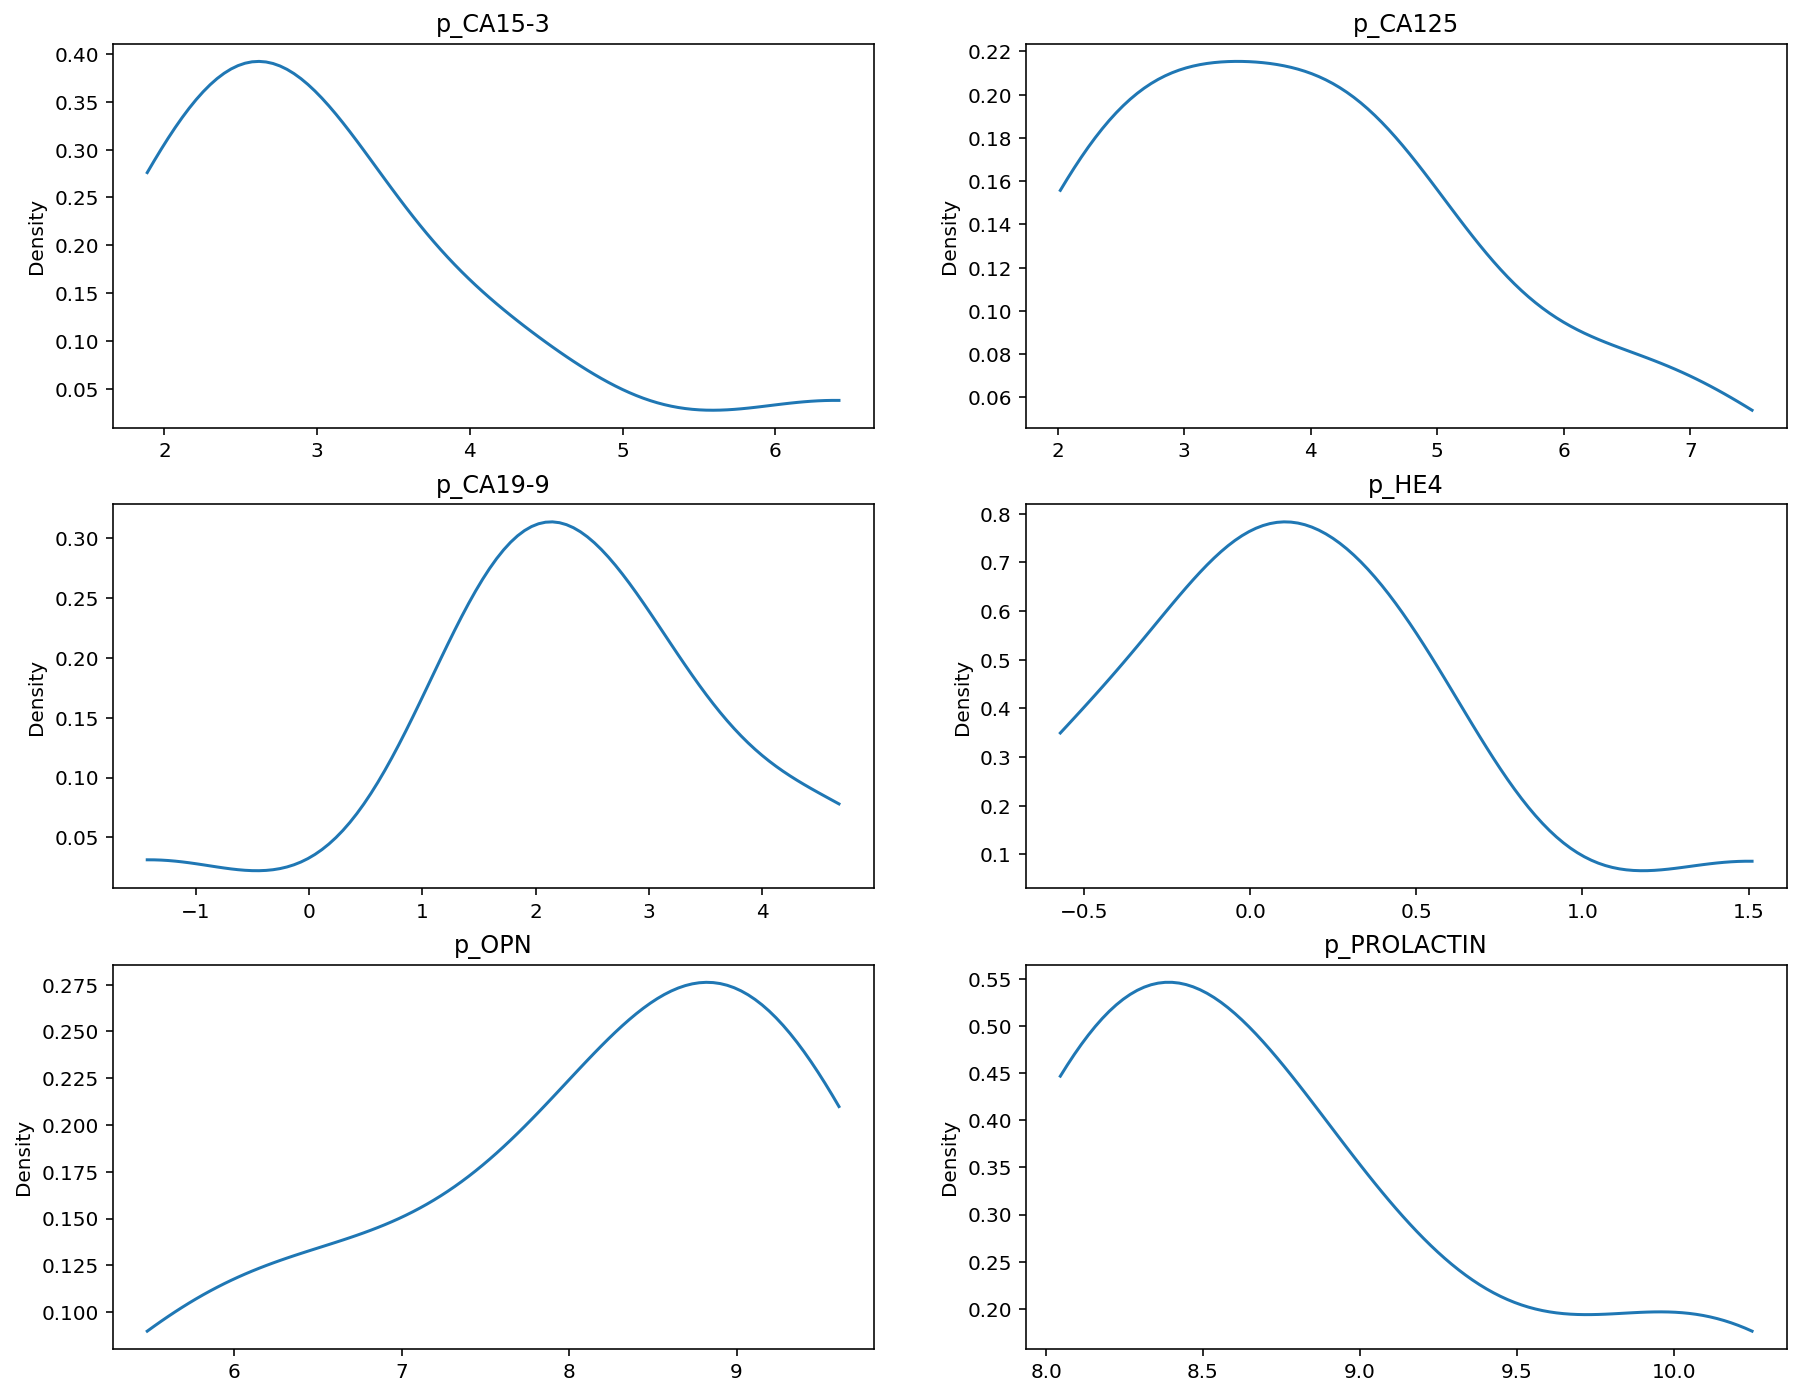

In [367]:
d_=dataset_sim.copy()
d_[markers]=np.log(d_[markers])
i_=int(np.ceil(len(markers)/2))
_,subs = plt.subplots(i_,2,figsize=(15,4*i_))
subs=subs.flatten()
for c_,m_ in enumerate(markers):
    ax=subs[c_]
    plt.sca(ax)
    IcePlot.linespace_kde(d_,m_,title=m_)

In [368]:
d_=dataset_sim.copy()
d_[markers]=np.log(d_[markers])
d_[markers] = d_[markers].rank()
px.parallel_coordinates(d_,markers+['s_Age']+['s_Time2dx'])

## PCA

In [369]:
d_=dataset_sim.copy()
markers_=[ 'p_CA125', 'p_HE4', 'p_PROLACTIN']
d_[markers_]=np.log(d_[markers_])
p_ = skpca(2).fit(d_[markers_])
d_ = p_.transform(d_[markers_])
d_ = pd.DataFrame(d_, columns=['pcax', 'pcay'])
d_['tumor']=dataset_sim.s_Tumor.values
d_['t2dx']=dataset_sim.s_Time2dx.values
px.scatter(d_, 'pcax', 'pcay',color='tumor',hover_data=['t2dx'])

## GMM

In [403]:
d_ = dataset_sim.copy()
markers_=[ 'p_CA125', 'p_HE4', 'p_PROLACTIN']
d_[markers_] = np.log(d_[markers_])
p_ = GaussianMixture(2, n_init=1, covariance_type='full',
                     init_params='random').fit(d_[markers_])
d_ = p_.predict_proba(d_[markers_])
d_ = pd.DataFrame(d_, columns=['p0', 'p1'])
d_['val_'] = (d_.p1 / d_.p0).values
d_['tumor'] = dataset_sim.s_Tumor.replace(['Normal', 'Ovary'], [0, 1]).values
d_['t2dx'] = dataset_sim.s_Time2dx.values

IcePlot.binroc(d_.tumor, d_.p0)

## Affin

In [387]:
d_=dataset_sim.copy()
markers_=[ 'p_CA125', 'p_HE4', 'p_PROLACTIN']
d_[markers_]=np.log(d_[markers_])
p_ = AffinityPropagation(preference=-10).fit(d_[markers_])
d_ = p_.predict(d_[markers_])
d_ = pd.DataFrame(d_, columns=['p0'])
d_['tumor']=dataset_sim.s_Tumor.replace(['Normal','Ovary'],[0,1]).values
d_['t2dx']=dataset_sim.s_Time2dx.values
d_

,p0,tumor,t2dx
0,0,0,-1.0
1,0,0,-1.0
2,0,0,-1.0
3,0,0,-1.0
4,2,0,-1.0
5,0,0,-1.0
6,0,0,-1.0
7,0,0,-1.0
8,1,1,96.0
9,2,1,46.0
